In [ ]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import datasets

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import silhouette_score

import time

In [ ]:
def remap_cluster_labels(labels):
  ''' map cluster target labels to integers '''
  mapping = {}
  current = 0
  for target in labels:
    if target not in mapping.values():
      mapping[current] = target
      current += 1

  new_labels = [mapping[k] for k in labels]
  return new_labels, mapping

In [ ]:
def bandwith_and_cluster(X, y_clusters_, initial_qnt=0.2, n_samples=100):
  ''' Find the bandwidth value and subsequently the clustering which gives a certain number of clusters'''
  n_clusters_ = float('inf')
  qnt = initial_qnt
  increment = 0.01
  retry = False 
  while True: 
    while (n_clusters_ > y_clusters_) or (retry == True):
      qnt += increment
      bandwidth = estimate_bandwidth(X, qnt, n_samples)
      start = time.time()
      clustering = MeanShift(bandwidth=bandwidth).fit(X)
      end = time.time()
      time_taken = end-start
      labels = clustering.labels_ 
      labels_unique = np.unique(labels)
      n_clusters_ = len(labels_unique)
      retry = False
    if y_clusters_ == n_clusters_:
      break
    else:
      print("\n too little clusters - retrying with qnt = " + str(qnt+increment))
      qnt -= increment
      increment = increment/2
      retry = True
  print("quantile: " + str(qnt))
  print("bandwidth: " + str(bandwidth))
  print("number of estimated clusters : %d" % n_clusters_)
  return labels, clustering, time_taken

In [ ]:
def same_cluster_stats(X, y, y_clusters_, initial_qnt=0.2, n_samples=100):
  ''' get metrics for clustering which gives a certain number of clusters '''
  print("\nfor same number of clusters: ")
  labels, clustering, time_taken = bandwith_and_cluster(X, y_clusters_, initial_qnt, n_samples)
  s_score = silhouette_score(X, labels, random_state=42)
  print("silhouette score: " + str(s_score))
  ar_score = adjusted_rand_score(y, labels)  
  print("adjusted rand score: " + str(ar_score))  

  labels, mapping = remap_cluster_labels(labels)
  print("time taken: " + str(time_taken))
  return labels, clustering, time_taken, s_score+ar_score

In [ ]:
def any_cluster_stats(X, y, qnt, n_samples=100):
  ''' get metrics for clustering with some defined quantile value '''
  print("\nfor any number of clusters: ")
  bandwidth = estimate_bandwidth(X, qnt, n_samples)
  start = time.time()
  clustering = MeanShift(bandwidth=bandwidth).fit(X)
  end = time.time()
  time_taken = end-start

  labels = clustering.labels_ 
  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)
  print("quantile: " + str(qnt))
  print("bandwidth: " + str(bandwidth))
  print("number of estimated clusters : %d" % n_clusters_)

  s_score = silhouette_score(X, labels, random_state=42)
  print("silhouette score: " + str(s_score))
  ar_score = adjusted_rand_score(y, labels)  
  print("adjusted rand score: " + str(ar_score))  

  labels, mapping = remap_cluster_labels(labels)
  print("time taken: " + str(time_taken))
  return labels, clustering, time_taken

In [ ]:
def get_highest_score_qnt(X, y_clusters_, initial_qnt=0.2, n_samples=100): 
  ''' get quantile of the bandwidth that gives the best aggregate score of the adjusted rand index and silhouette score'''
  qnt = initial_qnt
  total_score = 0
  while qnt <= 0.4:
    bandwidth = estimate_bandwidth(X, qnt, n_samples)
    clustering = MeanShift(bandwidth=bandwidth).fit(X)
    labels = clustering.labels_
    if len(set(labels)) > 1:
      s_score = silhouette_score(X, labels, random_state=42)
      ar_score = adjusted_rand_score(y, labels) 
    else:
      s_score = 0
      ar_score = 0
    if (s_score + ar_score) > total_score:
      total_score = s_score + ar_score
      best_qnt = qnt
    qnt += 0.05
  return best_qnt


In [ ]:
def best_cluster_stats(X, y, y_clusters_, initial_qnt=0.2, n_samples=100):
  ''' get the metrics for the clustering which gives the best aggregate adjusted rand index + silhouette score '''
  print("\nfor the best number of clusters: ")
  qnt = get_highest_score_qnt(X, y_clusters_, initial_qnt=0.2, n_samples=100)
  bandwidth = estimate_bandwidth(X, qnt, n_samples)
  start = time.time()
  clustering = MeanShift(bandwidth=bandwidth).fit(X)
  end = time.time()
  time_taken = end - start

  labels = clustering.labels_ 
  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)

  print("quantile: " + str(qnt))
  print("bandwidth: " + str(bandwidth))
  print("number of estimated clusters : %d" % n_clusters_)

  s_score = silhouette_score(X, labels, random_state=42)
  print("silhouette score: " + str(s_score))
  ar_score = adjusted_rand_score(y, labels)  
  print("adjusted rand score: " + str(ar_score))  

  labels, mapping = remap_cluster_labels(labels)
  print("time taken: " + str(time_taken))
  return labels, clustering, time_taken, s_score+ar_score

In [ ]:
def convert_colours(labels):
  colour_map = {0: '#3399FF',
  1: '#F6E461',
  2: '#71DB99', 
  3: '#ADA8B6', 
  4: '#FFEEDB', 
  5: '#4C3B4D'}
  colours = []
  for i in labels:
    colours.append(colour_map[i])
  return colours

#  1 - Getting and visualizing best clusters

*clusters are evaluated by their aggregate Adjusted Rand Index and Silhouette Score (i.e., adjusted rand index + silhouette score)

## **iris dataset**

In [ ]:
# iris dataset
iris = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'target']).sort_values('target')

X = iris_df.drop(columns='target', inplace=False)
X = StandardScaler().fit_transform(X)

y = iris_df['target']
y_clusters_ = len(iris_df['target'].unique())

initial_qnt = 0.2
labels, clustering, time_taken, total_score = same_cluster_stats(X, y, y_clusters_, initial_qnt, len(iris_df))

qnt = 0.2
any_cluster_stats(X, y, qnt, len(iris_df))

best_labels, best_clustering, best_time_taken, best_total_score = best_cluster_stats(X, y, y_clusters_, len(iris_df))

print("best cluster score: " + str(best_total_score)) 

# Because the clustering to get a certain number of clusters may result in a more precise bandwidth, 
# it could result in a aggregate score better than calculated in the best_cluster_stats function

# Hence - checks if the best total score is of the clustering computed with 0.05 quantile intervals between 0.2 to 0.4 (from 'best_cluster_stats'),
# or the clustering with the eventual number of clusters set as a predetermined value (from 'same_cluster_stats')
if best_total_score>total_score:
  labels, clustering, time_taken, total_score = best_labels, best_clustering, best_time_taken, best_total_score
  print("\nbest clustering <> same cluster")
  # best total score is from 'best_cluster_stats'
else: 
  print("\nbest clustering == same cluster")
  # best total score is from 'same_cluster_stats'


for same number of clusters: 
quantile: 0.26000000000000006
bandwidth: 1.435214079983524
number of estimated clusters : 3
silhouette score: 0.43251408537574937
adjusted rand score: 0.560024437429997
time taken: 0.6507308483123779

for any number of clusters: 
quantile: 0.2
bandwidth: 1.207017869625092
number of estimated clusters : 4
silhouette score: 0.35847426830300005
adjusted rand score: 0.5361785571822143
time taken: 0.8141813278198242

for the best number of clusters: 
quantile: 0.3
bandwidth: 1.6753865802295078
number of estimated clusters : 2
silhouette score: 0.5817500491982808
adjusted rand score: 0.5681159420289855
time taken: 0.4780135154724121
best cluster score: 1.1498659912272662

best clustering <> same cluster


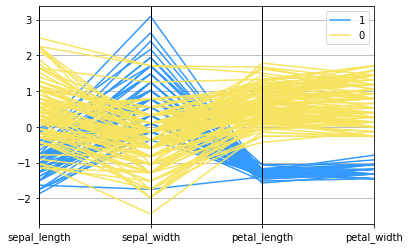

In [ ]:
iris_df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] = X
iris_df['cluster'] = clustering.labels_
pd.plotting.parallel_coordinates(iris_df.drop(columns='target', inplace=False), 'cluster', color=('#3399FF', '#F6E461', '#71DB99'))

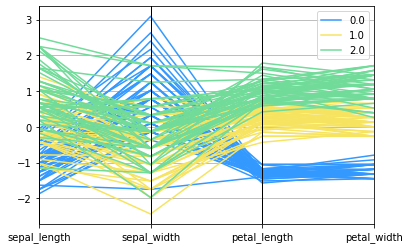

In [ ]:
pd.plotting.parallel_coordinates(iris_df.drop(columns='cluster', inplace=False), 'target', color=('#3399FF', '#F6E461', '#71DB99'))

## **wine dataset**

In [ ]:
wine = datasets.load_wine()
wine_df = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target']).sort_values('target')

scaler = StandardScaler()
wine_df[['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline']] = scaler.fit_transform(wine_df[['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline']])

X = wine_df.drop(columns='target', inplace=False)
y = wine_df['target']
y_clusters_ = len(wine_df['target'].unique())

initial_qnt = 0.2
labels, clustering, time_taken, total_score = same_cluster_stats(X, y, y_clusters_, initial_qnt, len(wine_df))

qnt = 0.2
any_cluster_stats(X, y, qnt, len(wine_df))

best_labels, best_clustering, best_time_taken, best_total_score = best_cluster_stats(X, y, y_clusters_, initial_qnt=0.2, n_samples=len(wine_df))

if best_total_score>total_score:
  labels, clustering, time_taken, total_score = best_labels, best_clustering, best_time_taken, best_total_score
  print("\nbest clustering <> same cluster")
else: 
  print("\nbest clustering == same cluster")


for same number of clusters: 
quantile: 0.26000000000000006
bandwidth: 3.876723011793166
number of estimated clusters : 3
silhouette score: 0.19124355425359305
adjusted rand score: -0.009444351812084991
time taken: 1.4043474197387695

for any number of clusters: 
quantile: 0.2
bandwidth: 3.5510730756149598
number of estimated clusters : 6
silhouette score: 0.19807240260939726
adjusted rand score: 0.3642912563240469
time taken: 0.9529950618743896

for the best number of clusters: 
quantile: 0.2
bandwidth: 3.5510730756149598
number of estimated clusters : 6
silhouette score: 0.19807240260939726
adjusted rand score: 0.3642912563240469
time taken: 0.91925048828125

best clustering <> same cluster


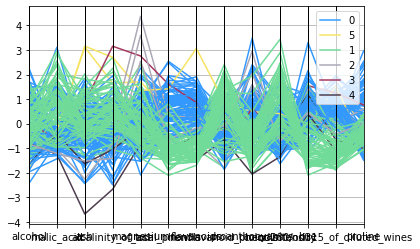

In [ ]:
wine_df['cluster'] = clustering.labels_
pd.plotting.parallel_coordinates(wine_df.drop(columns='target', inplace=False), 'cluster', color=('#3399FF', '#F6E461', '#71DB99', '#ADA8B6', '#A53860', '#4C3B4D'))

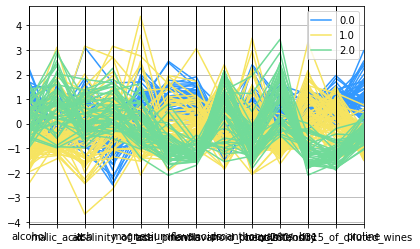

In [ ]:
pd.plotting.parallel_coordinates(wine_df.drop(columns='cluster', inplace=False), 'target',color=('#3399FF', '#F6E461', '#71DB99'))

## **noisy circles**

In [ ]:
def bandwith_and_cluster(X, y_clusters_, initial_qnt=0.2, n_samples=100):
  n_clusters_ = float('inf')
  qnt = initial_qnt
  increment = 0.01
  retry = False 
  while True: 
    while (n_clusters_ > y_clusters_) or (retry == True):
      qnt += increment
      bandwidth = estimate_bandwidth(X, qnt, n_samples)
      start = time.time()
      clustering = MeanShift(bandwidth=bandwidth).fit(X)
      end = time.time()
      time_taken = end-start
      labels = clustering.labels_ 
      labels_unique = np.unique(labels)
      n_clusters_ = len(labels_unique)
      retry = False
    if y_clusters_ == n_clusters_:
      break
    else:
      qnt -= increment
      increment = increment/2
      retry = True
  print("quantile: " + str(qnt))
  print("bandwidth: " + str(bandwidth))
  print("number of estimated clusters : %d" % n_clusters_)
  return labels, clustering, time_taken

In [ ]:
# reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05, random_state=10)
X, y = noisy_circles
y_clusters_ = 2


initial_qnt = 0.2
labels, clustering, time_taken, total_score = same_cluster_stats(X, y, y_clusters_, initial_qnt, n_samples=500)

qnt = 0.2
any_cluster_stats(X, y, qnt)

best_labels, best_clustering, best_time_taken, best_total_score = best_cluster_stats(X, y, y_clusters_, n_samples=500)
print("best total: " + str(best_total_score))

if best_total_score>total_score:
  labels, clustering, time_taken, total_score = best_labels, best_clustering, best_time_taken, best_total_score
  print("\nbest clustering <> same cluster")
else: 
  print("\nbest clustering == same cluster")


for same number of clusters: 
quantile: 0.3050000000000001
bandwidth: 0.744964939509239
number of estimated clusters : 2
silhouette score: 0.352238572686947
adjusted rand score: -0.0006603981322957055
time taken: 11.550416469573975

for any number of clusters: 
quantile: 0.2
bandwidth: 0.5766587590277009
number of estimated clusters : 4
silhouette score: 0.366641164361556
adjusted rand score: -0.000862808679635365
time taken: 11.600011110305786

for the best number of clusters: 
quantile: 0.3
bandwidth: 0.7382657959483474
number of estimated clusters : 3
silhouette score: 0.386980753326551
adjusted rand score: -0.0008607157345018265
time taken: 12.206612586975098
best total: 0.3861200375920492

best clustering <> same cluster


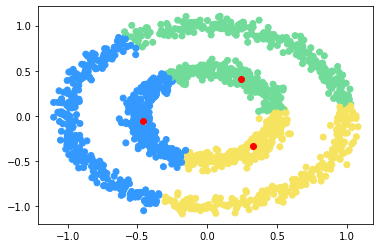

In [ ]:
circles_df = pd.DataFrame(columns = ['x', 'y', 'target'], data = np.c_[X, y])
circles_df['target'] = circles_df['target'].astype('int')

cluster_centers = clustering.cluster_centers_
plt.scatter(circles_df['x'], circles_df['y'], c=convert_colours(labels))
plt.scatter(list(cluster_centers[:, 0]), list(cluster_centers[:, 1]), color='red')

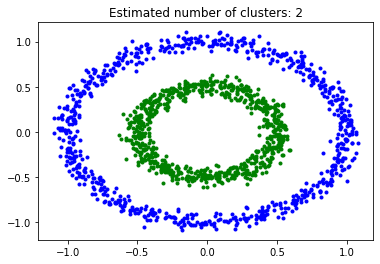

In [ ]:
y_clusters_ = len(np.unique(y))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(y_clusters_), colors):
    my_members = y == k
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
plt.title('Estimated number of clusters: %d' % y_clusters_)
plt.show()

## **aniso**

In [ ]:
random_state = 42
n_samples = 1500
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
X = X_aniso

In [ ]:
aniso_df = pd.DataFrame(data= np.c_[X, y],
                     columns= ['X1', 'X2', 'target']).sort_values('target')
X = aniso_df.drop(columns='target', inplace=False)
y = aniso_df['target']

In [ ]:
# finding bandwidth and clustering
y_clusters_ = 3


initial_qnt = 0.28
labels, clustering, time_taken, total_score = same_cluster_stats(X, y, y_clusters_, initial_qnt, n_samples=500)

qnt = 0.2
any_cluster_stats(X, y, qnt)

best_labels, best_clustering, best_time_taken, best_total_score = best_cluster_stats(X, y, y_clusters_, n_samples=500)

if best_total_score>total_score:
  labels, clustering, time_taken, total_score = best_labels, best_clustering, best_time_taken, best_total_score
  print("\nbest clustering <> same cluster")
else: 
  print("\nbest clustering == same cluster")


for same number of clusters: 
quantile: 0.29000000000000004
bandwidth: 3.3952447452844288
number of estimated clusters : 3
silhouette score: 0.7751261784144114
adjusted rand score: 0.9723587418316461
time taken: 4.610620737075806

for any number of clusters: 
quantile: 0.2
bandwidth: 2.295454680716126
number of estimated clusters : 4
silhouette score: 0.6875319543792396
adjusted rand score: 0.9453359640520999
time taken: 7.387133359909058

for the best number of clusters: 
quantile: 0.3
bandwidth: 3.6160183696888537
number of estimated clusters : 3
silhouette score: 0.7751261784144114
adjusted rand score: 0.9723587418316461
time taken: 4.141704559326172

best clustering == same cluster


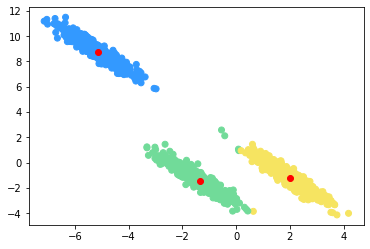

In [ ]:
aniso_df = pd.DataFrame(columns = ['x', 'y', 'target'], data = np.c_[X, y])
aniso_df['target'] = aniso_df['target'].astype('int')

cluster_centers = clustering.cluster_centers_
plt.scatter(aniso_df['x'], aniso_df['y'], c=convert_colours(labels))
plt.scatter(list(cluster_centers[:, 0]), list(cluster_centers[:, 1]), color='red')

## **varied blobs**

In [ ]:
n_samples = 1500
X, y = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state = 42)
y_clusters_ = 3

initial_qnt = 0.28
labels, clustering, time_taken, total_score = same_cluster_stats(X, y, y_clusters_, initial_qnt, n_samples=500)

qnt = 0.2
any_cluster_stats(X, y, qnt)

best_labels, best_clustering, best_time_taken, best_total_score = best_cluster_stats(X, y, y_clusters_, n_samples=500)

if best_total_score>total_score:
  labels, clustering, time_taken, total_score = best_labels, best_clustering, best_time_taken, best_total_score
  print("\nbest clustering <> same cluster")
else: 
  print("\nbest clustering == same cluster")


for same number of clusters: 
quantile: 0.29000000000000004
bandwidth: 3.3952447452844288
number of estimated clusters : 3
silhouette score: 0.7751261784144114
adjusted rand score: 0.9723587418316461
time taken: 4.64004373550415

for any number of clusters: 
quantile: 0.2
bandwidth: 2.295454680716126
number of estimated clusters : 4
silhouette score: 0.6875319543792396
adjusted rand score: 0.9453359640520999
time taken: 7.323585033416748

for the best number of clusters: 
quantile: 0.3
bandwidth: 3.6160183696888537
number of estimated clusters : 3
silhouette score: 0.7751261784144114
adjusted rand score: 0.9723587418316461
time taken: 4.152843952178955

best clustering == same cluster


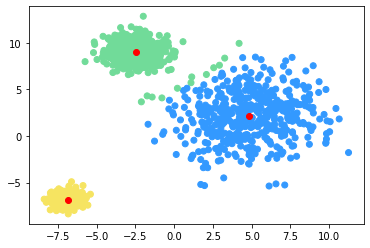

In [ ]:
blobs_df = pd.DataFrame(columns = ['x', 'y', 'target'], data = np.c_[X, y])
blobs_df['target'] = blobs_df['target'].astype('int')

cluster_centers = clustering.cluster_centers_
plt.scatter(blobs_df['x'], blobs_df['y'], c=convert_colours(labels))
plt.scatter(list(cluster_centers[:, 0]), list(cluster_centers[:, 1]), color='red')

# 2 - Investigating the effect of bandwidth values (by varying quantile) 

In [ ]:
aniso_results = pd.DataFrame(columns = ['quantile', 'bandwidth', 'num_clusters', 'silhouette', 'adj_rand'])

In [ ]:
random_state = 42
n_samples = 1500
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
X = X_aniso

aniso_df = pd.DataFrame(data= np.c_[X, y],
                     columns= ['X1', 'X2', 'target']).sort_values('target')
X = aniso_df.drop(columns='target', inplace=False)
y = aniso_df['target']

In [ ]:
quantile = 0.25
n_samples = 500
while quantile <= 0.36:
  bandwidth = estimate_bandwidth(X, quantile, n_samples)
  clustering = MeanShift(bandwidth=bandwidth).fit(X)

  labels = clustering.labels_ 
  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)
  if len(set(labels)) > 1:
    s_score = silhouette_score(X, labels, random_state=42)
    ar_score = adjusted_rand_score(y, labels) 
  else:
    s_score = 0
    ar_score = 0

  aniso_results.loc[len(aniso_results)] = [quantile, bandwidth, n_clusters_, s_score, ar_score]

  quantile += 0.02

aniso_results

,quantile,bandwidth,num_clusters,silhouette,adj_rand
0,0.25,1.826524,3.0,0.701486,0.988056
1,0.27,2.045222,3.0,0.701486,0.988056
2,0.29,2.293503,3.0,0.701486,0.988056
3,0.31,2.659375,2.0,0.808030,0.571102
4,0.33,4.395657,2.0,0.808030,0.571102
5,0.35,4.923205,2.0,0.808030,0.571102


In [ ]:
wine_results = pd.DataFrame(columns = ['quantile', 'bandwidth', 'num_clusters', 'silhouette', 'adj_rand'])

In [ ]:
X = wine_df.drop(columns='target', inplace=False)
y = wine_df['target']

In [ ]:
quantile = 0.25
n_samples = 500
while quantile <= 0.36:
  bandwidth = estimate_bandwidth(X, quantile, n_samples)
  clustering = MeanShift(bandwidth=bandwidth).fit(X)

  labels = clustering.labels_ 
  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)
  if len(set(labels)) > 1:
    s_score = silhouette_score(X, labels, random_state=42)
    ar_score = adjusted_rand_score(y, labels) 
  else:
    s_score = 0
    ar_score = 0

  wine_results.loc[len(wine_results)] = [quantile, bandwidth, n_clusters_, s_score, ar_score]

  quantile += 0.02

wine_results

,quantile,bandwidth,num_clusters,silhouette,adj_rand
0,0.25,3.874574,5.0,0.206382,-0.011140
1,0.27,3.998752,5.0,0.206382,-0.011140
2,0.29,4.090474,5.0,0.206382,-0.011140
3,0.31,4.233724,5.0,0.206382,-0.011140
4,0.33,4.341508,4.0,0.232250,-0.008423
5,0.35,4.482242,3.0,0.246976,-0.008359


# 3 - Plotting the number of clusters

In [ ]:
X = wine_df.drop(columns='target', inplace=False)
y = wine_df['target']

In [ ]:
quantile = 0.1
n_samples = 500
bw_list = []
clusters_list = []

while quantile <= 0.50:
  bandwidth = estimate_bandwidth(X, quantile, n_samples)
  clustering = MeanShift(bandwidth=bandwidth).fit(X)

  labels = clustering.labels_ 
  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)
  bw_list.append(bandwidth)
  clusters_list.append(n_clusters_)
  

  quantile += 0.02


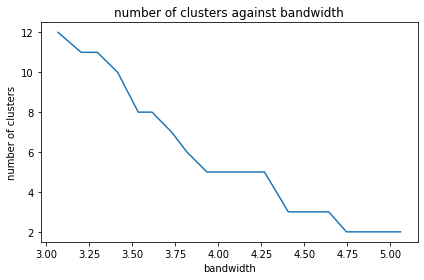

In [ ]:
# plot
plt.figure(1)
plt.plot(bw_list, clusters_list)
plt.title('number of clusters against bandwidth')
plt.ylabel('number of clusters')
plt.xlabel('bandwidth')
plt.tight_layout()

In [ ]:
random_state = 42
n_samples = 1500
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
X = X_aniso

aniso_df = pd.DataFrame(data= np.c_[X, y],
                     columns= ['X1', 'X2', 'target']).sort_values('target')
X = aniso_df.drop(columns='target', inplace=False)
y = aniso_df['target']

In [ ]:
quantile = 0.1
n_samples = 500
bw_list = []
clusters_list = []

while quantile <= 0.50:
  bandwidth = estimate_bandwidth(X, quantile, n_samples)
  clustering = MeanShift(bandwidth=bandwidth).fit(X)

  labels = clustering.labels_ 
  labels_unique = np.unique(labels)
  n_clusters_ = len(labels_unique)
  bw_list.append(bandwidth)
  clusters_list.append(n_clusters_)
  

  quantile += 0.02


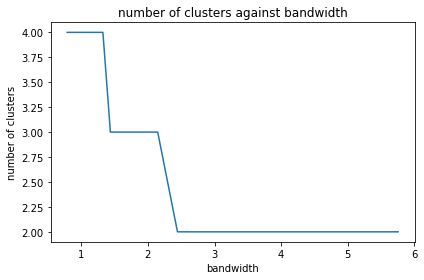

In [ ]:
# plot
plt.figure(1)
plt.plot(bw_list, clusters_list)
plt.title('number of clusters against bandwidth')
plt.ylabel('number of clusters')
plt.xlabel('bandwidth')
plt.tight_layout()